In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

!pip install pydicom

import sys
!{sys.executable} -m pip install --quiet --no-cache-dir --upgrade pip

import sys
!{sys.executable} -m pip install opencv-python

In [43]:
import numpy as np #    
import matplotlib
import tkinter

import pylab # модуль для построения графиков
import matplotlib.pyplot as plt #                                                              +                        
import cv2
import ipywidgets as widgets
from PIL import ImageEnhance
from PIL import Image # отрисовка изображений

from skimage import io, color
from skimage import util
import matplotlib.pyplot as plt
from IPython.display import display

In [44]:
import matplotlib.image as mpimg 
import os
from tensorflow.keras.preprocessing import image

In [45]:
import pydicom
from skimage.transform import rotate

# 1. Общие действия

### 1.1 количество снимков в полученной папке unhealthy

In [46]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy'
photo_count = count_photos(folder_path)
print(photo_count)

1113


### 1.2 анализ файлов в папке 'unhealthy'

#### 1.2.1 серия 0002

In [47]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0002-00808.dcm"
dcm_data = pydicom.dcmread(dcm_file)

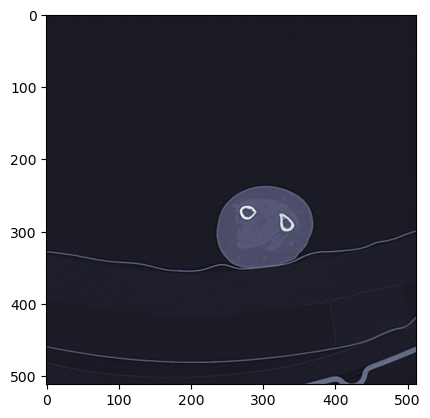

In [48]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

#### 1.2.2 серия 0003

In [49]:
# Загрузка файла DICOM
dcm_file = "unhealthy/IMG-0003-00001.dcm"
dcm_data = pydicom.dcmread(dcm_file)

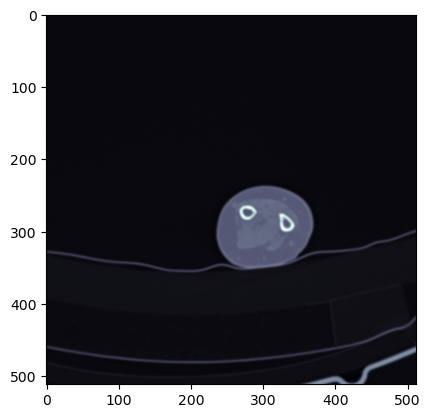

In [50]:
# Конвертация в изображение PIL
image = Image.fromarray(dcm_data.pixel_array)

# Отображение изображения
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

Зеркальный файл и зеркальная серия, удалить

#### УСТАНОВКА НОВЫХ БИБЛИОТЕК

!pip install Simpleitk
!pip install scipy
!pip install scikit-image

#### БИБЛИОТЕКИ ДЛЯ 3D ВИЗУАЛИЗАЦИИ 'vtk' И 'mayavi'

!pip install vtk 
!pip install  mayavi

### 1.3 создание папки "unhealthy1", содержащей только файлы серии 0002 

In [51]:
import shutil

# Директория с исходными DICOM файлами
source_directory = 'unhealthy'
# Директория для файлов серии 0002
destination_directory = 'unhealthy1'

# Создание новой директории, если она не существует
os.makedirs(destination_directory, exist_ok=True)

# Список всех файлов в исходной директории
files = os.listdir(source_directory)

# Фильтрация и копирование файлов серии 0002
for file_name in files:
    if '0002' in file_name:
        source_file = os.path.join(source_directory, file_name)
        destination_file = os.path.join(destination_directory, file_name)
        shutil.copy2(source_file, destination_file)

print("Files from series 0002 have been copied to the new directory.")

Files from series 0002 have been copied to the new directory.


In [52]:
def count_photos(folder_path):
    photo_extensions = ['.dcm']
    count = 0
    for file_name in os.listdir(folder_path):
        _, extension = os.path.splitext(file_name)
        if extension.lower() in photo_extensions:
            count += 1
    return count

folder_path = 'unhealthy1'
photo_count = count_photos(folder_path)
print(photo_count)

819


### 1.4 проверка наличия пиксельных данных и удаление пустых файлов

In [53]:
# Директория с DICOM файлами
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]

print(f"Found {len(files)} DICOM files in the directory.")

Found 819 DICOM files in the directory.


In [54]:
files_without_images = []

for file_name in files:
    file_path = os.path.join(directory, file_name)
    try:
        dcm = pydicom.dcmread(file_path)
        if not hasattr(dcm, 'PixelData'):
            print(f"File {file_name} does not contain image data. Deleting...")
            os.remove(file_path)
            files_without_images.append(file_name)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

print(f"Removed {len(files_without_images)} files that do not contain image data.")

Removed 0 files that do not contain image data.


# 2. Проверки и преобразования изображений массива

### 2.1 Проверка размеров изображений

Перед визуализацией проверить все ли изображения имеют одинаковые размеры.

In [55]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

In [56]:
# Проверка размеров изображений
sizes = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    sizes.append(dcm.pixel_array.shape)

In [57]:
unique_sizes = set(sizes)
print(f"Unique image sizes: {unique_sizes}")

if len(unique_sizes) > 1:
    print("Warning: Not all DICOM files have the same size.")

Unique image sizes: {(512, 512)}


### 2.2 Нормализация изображений

Если размеры не совпадают, нормализовать их до одного размера

In [58]:
from skimage.transform import resize

# Выберем минимальные размеры как базовые
base_height, base_width = min(sizes)
# Можно также выбрать максимальные размеры для базовых, чтобы избежать потерь данных
# base_height, base_width = max(sizes)

resized_slices = []
for f in files:
    dcm = pydicom.dcmread(os.path.join(directory, f))
    image = dcm.pixel_array
    if image.shape != (base_height, base_width):
        image_resized = resize(image, (base_height, base_width), anti_aliasing=True)
        image_resized = (image_resized * 65535).astype(np.uint16)  # Приведение к типу данных DICOM
    else:
        image_resized = image
    
    resized_slices.append(image_resized)

volume = np.stack(resized_slices, axis=-1)

### 2.3 Проверка ориентации и позиционирования

DICOM файлы могут содержать информацию о положении и ориентации изображений. Ориентируем изображения по оси Z предварительно сортируя их

In [59]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    return dcm.pixel_array, dcm.ImagePositionPatient

# Читаем все DICOM файлы и получаем их ImagePositionPatient атрибут и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (ось пациента)

volume = np.stack([s[0] for s in slices], axis=-1)

Проверка наличия атрибута: Добавить проверку наличия атрибута ImagePositionPatient перед его использованием.
Использование альтернативных атрибутов: Если ImagePositionPatient отсутствует, упорядочить файлы на основе других атрибутов, таких как InstanceNumber или SliceLocation

In [60]:
directory = 'unhealthy1'
files = [f for f in os.listdir(directory) if f.endswith('.dcm')]
files.sort()

def read_dicom(file_path):
    dcm = pydicom.dcmread(file_path)
    image = dcm.pixel_array
    
    if 'ImagePositionPatient' in dcm:
        position = dcm.ImagePositionPatient
    elif 'InstanceNumber' in dcm:
        position = [0, 0, dcm.InstanceNumber]  # Выделяем позицию по InstanceNumber
    elif 'SliceLocation' in dcm:
        position = [0, 0, dcm.SliceLocation]  # Выделяем позицию по SliceLocation
    else:
        raise AttributeError(f"File {file_path} lacks position information.")
    
    return image, position

# Читаем все DICOM файлы и получаем их позицию и изображение
slices = [read_dicom(os.path.join(directory, f)) for f in files]
slices.sort(key=lambda s: s[1][2])  # Сортируем по Z координате (или ее альтернативе)

# Создаем объемный массив из нормализованных изображений
volume = np.stack([s[0] for s in slices], axis=-1)
print(volume.shape)

(512, 512, 819)


# 3. Визуализация по проекцим

### 3.1 Прямая визуализация с исходной контрастностью

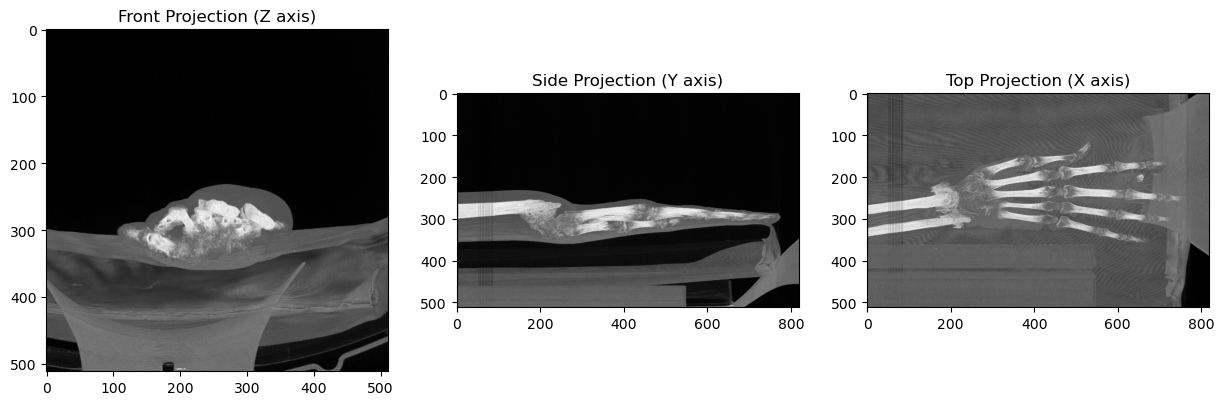

In [61]:
# Front projection (по оси Z)
projection_z = np.max(volume, axis=2)

# Side projection (по оси Y)
projection_y = np.max(volume, axis=1)

# Top projection (по оси X)
projection_x = np.max(volume, axis=0)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_z, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()

# 4. Числовые значения в проекциях массива

### 4.1 Top projection (по оси X)

In [62]:
# Top projection (по оси X)
projection_x = np.max(volume, axis=0)

In [63]:
projection_x

array([[8355, 8389, 8374, ..., 8733, 8708, 8686],
       [8317, 8406, 8403, ..., 8660, 8655, 8678],
       [8296, 8339, 8326, ..., 8681, 8712, 8715],
       ...,
       [8649, 8620, 8625, ..., 7257, 7234, 7238],
       [8633, 8628, 8600, ..., 7260, 7249, 7260],
       [8677, 8718, 8675, ..., 7287, 7250, 7262]], dtype=uint16)

In [64]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


In [65]:
projection_x.shape

(512, 819)

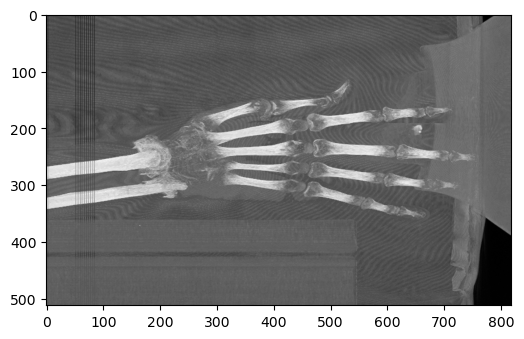

In [66]:
from skimage.transform import rotate
plt.figure(figsize=(6, 6))
plt.imshow(projection_x,cmap='gray')
plt.show()

### 4.2 Проверка значений в массиве по координатам

In [67]:
projection_x[100][750]

8891

In [68]:
projection_x[500][800]

7252

In [69]:
projection_x[275][5]

10528

### 4.3 Расчёты для преобразования в стандартные значения пикселей

In [70]:
print(projection_x.max())
print(projection_x.min())
print(projection_x.mean())

11024
7217
8688.573467548076


In [71]:
# разность значений
p = projection_x.max() - projection_x.min()
p

3807

In [72]:
# Соотношение значений пикселей
s = int(p / 256 + 1)
s

15

In [73]:
# приведённый массив "с нулями в минимуме"
projection_xp = projection_x - 7217
projection_xp

array([[1138, 1172, 1157, ..., 1516, 1491, 1469],
       [1100, 1189, 1186, ..., 1443, 1438, 1461],
       [1079, 1122, 1109, ..., 1464, 1495, 1498],
       ...,
       [1432, 1403, 1408, ...,   40,   17,   21],
       [1416, 1411, 1383, ...,   43,   32,   43],
       [1460, 1501, 1458, ...,   70,   33,   45]], dtype=uint16)

In [74]:
# приведённый массив к размерности .png
projection_xpp = np.floor(projection_xp / s) # ceil
projection_xpp

array([[ 75.,  78.,  77., ..., 101.,  99.,  97.],
       [ 73.,  79.,  79., ...,  96.,  95.,  97.],
       [ 71.,  74.,  73., ...,  97.,  99.,  99.],
       ...,
       [ 95.,  93.,  93., ...,   2.,   1.,   1.],
       [ 94.,  94.,  92., ...,   2.,   2.,   2.],
       [ 97., 100.,  97., ...,   4.,   2.,   3.]])

In [75]:
print(projection_xpp.max())
print(projection_xpp.min())
print(projection_xpp.mean())

253.0
0.0
97.63804229624542


# 5. Перевод изображения в формат "___.png"

#### 5.1 сохранение обычного изображения В РАЗМЕРЕ МАССИВА и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ

In [76]:
projection_xpp = projection_xpp.astype(np.uint8)
image = Image.fromarray(projection_xpp)

# Сохранение изображения в файл .png
image.save('image1_a.png')

In [77]:
# Загрузка изображения
image = cv2.imread('image1_a.png')

# Получение размера изображения
height, width, channels = image.shape

print(f"Размер изображения: {width}x{height} пикселей")

Размер изображения: 819x512 пикселей


In [78]:
# Загрузка изображения
image = cv2.imread('image1_a.png')

# Получение количества каналов
num_channels = image.shape[2]

print(f"Количество слоев (каналов) в изображении: {num_channels}")

Количество слоев (каналов) в изображении: 3


##### Преобразовать изображение в одноканальное (оттенки серого)

In [83]:
image = cv2.imread('image1_a.png')

# Преобразование изображения в оттенки серого
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Размер преобразованного изображения
print(gray_image.shape)  # Выведет: (512, 819)

# Количество каналов преобразованного изображения
print(gray_image.ndim)  # Выведет: 2 (одноканальное изображение)

# Сохранение одноканального изображения
cv2.imwrite('gray_image1_a.png', gray_image)

(512, 819)
2


True

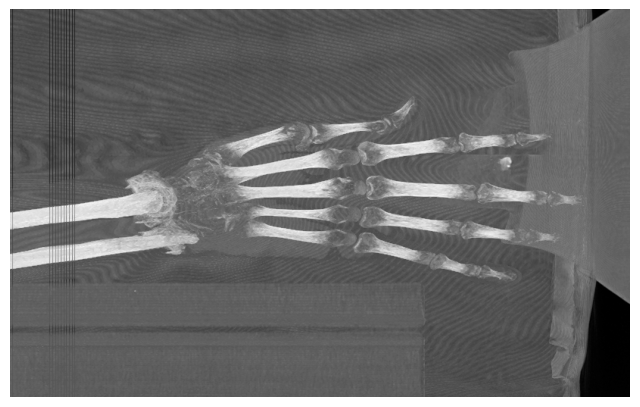

In [84]:
gray_image = mpimg.imread('gray_image1_a.png')

# Отображение изображения в оттенках серого
plt.figure(figsize=(8, 8))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

#### 5.2 создание и сохранение контрастного изображения

In [85]:
image22 = Image.open('gray_image1_a.png')
                
enhancer = ImageEnhance.Contrast(image22) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(2.0) # Увеличение контрастности в 2 раза
enhanced_image.save('image1_contrast_a.png')

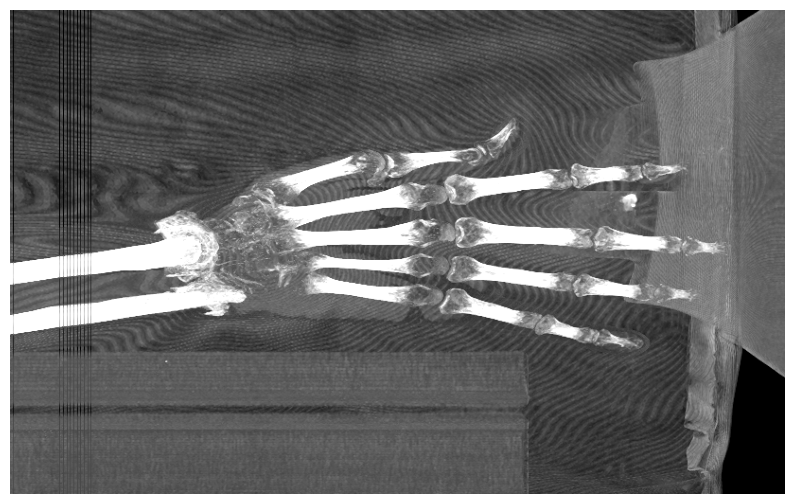

In [86]:
plt.figure(figsize=(10, 10))
image71 = mpimg.imread('image1_contrast_a.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71, cmap='gray') # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

<h3 style="color:red;">5.3 определение угла между осью кости и горизонтом</h3>

In [87]:
import cv2
import numpy as np

# Чтение изображения
image = cv2.imread('image1_contrast_a.png')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: image1_contrast.png')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
drawing = False

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.1f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.1f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('image1_contrast_edited_a.png', overlay)

cv2.destroyAllWindows()

Угол между линией №1 и горизонтом: 8.0 градусов
Горизонтальная линия нарисована через точку: (802, 167)


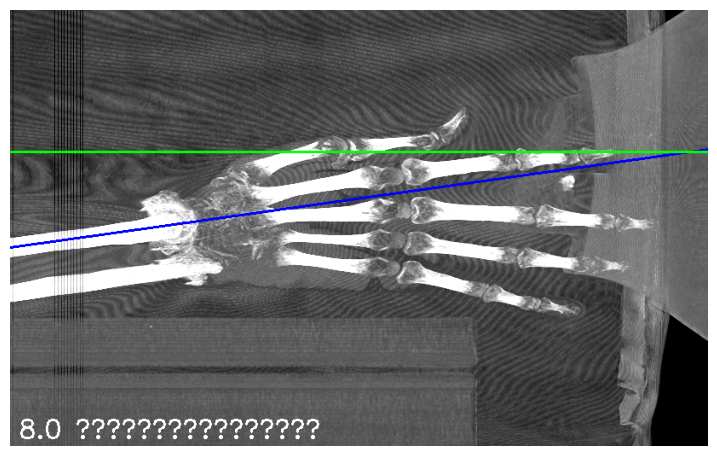

In [88]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('image1_contrast_edited_a.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

# 6. Поворот X и Y плоскостей вокруг оси Y с заданным углом поворота

Original volume shape: (512, 512, 819)
Rotated volume shape: (512, 512, 819)


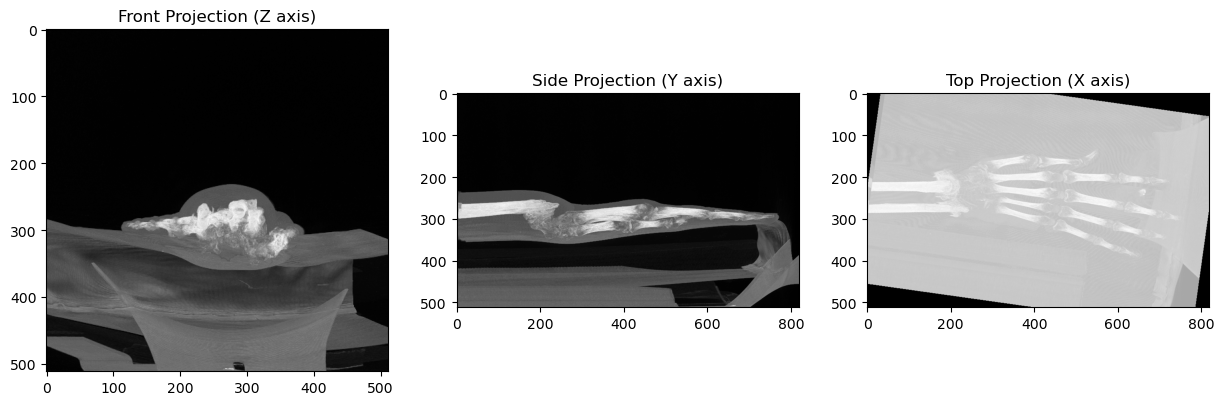

In [89]:
import os
import numpy as np
import pydicom
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def read_dicom_images(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort()
    slices = [pydicom.dcmread(f).pixel_array for f in files]
    volume = np.stack(slices, axis=-1)
    return volume

def rotate_volume(volume, angle):
    # Поворот объёма вокруг оси Z
    rotated_volume = rotate(volume, angle, axes=(1, 2), reshape=False)
    return rotated_volume

def get_projections(volume):
    projection_xx = np.flip(np.max(volume, axis=0), axis=1)
    projection_yy = np.flip(np.max(volume, axis=1), axis=1)
    projection_zz = np.flip(np.max(volume, axis=2), axis=1)
    return projection_xx, projection_yy, projection_zz

# Путь к директории с DICOM изображениями
directory = 'unhealthy1'

# Чтение и нормализация изображения
volume = read_dicom_images(directory)
#volume_normalized = normalize_images(volume)
print("Original volume shape:", volume.shape)

# Угол поворота 
angle = 8.0

# Поворот объёма вокруг оси Z
rotated_volume = rotate_volume(volume, angle)
print("Rotated volume shape:", rotated_volume.shape)

# Получение проекций после поворота
projection_x1, projection_y1, projection_z1 = get_projections(rotated_volume)

# Визуализация проекций
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(projection_z1, cmap='gray')
axs[0].set_title('Front Projection (Z axis)')

axs[1].imshow(projection_y1, cmap='gray')
axs[1].set_title('Side Projection (Y axis)')

axs[2].imshow(projection_x1, cmap='gray')
axs[2].set_title('Top Projection (X axis)')

plt.show()


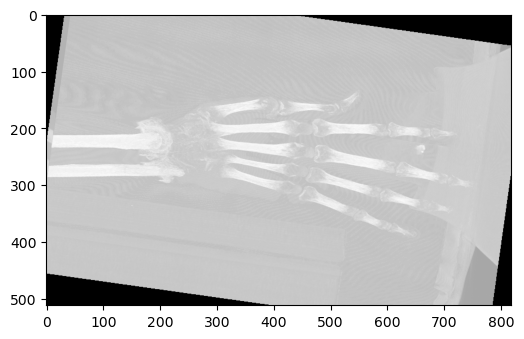

In [90]:
from skimage.transform import rotate
plt.figure(figsize=(6, 6))
plt.imshow(projection_x1,cmap='gray')
plt.show()

# 7. Числовые значения в проекциях массива

#### 7.1 Top projection (по оси X)

In [91]:
projection_x1[10][800]

0

In [92]:
projection_x1[100][296]

8412

In [93]:
projection_x1[275][100]

10435

In [94]:
projection_x1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

#### 7.2 Расчёты для преобразования в стандартные значения пикселей

In [95]:
print(projection_x1.max())
print(projection_x1.min())
print(projection_x1.mean())

11039
0
8102.3531984508545


#### 7.3 Преобразовать тип uint16 в int32

In [96]:
# ИНАЧЕ НЕ ВЫЧИТАЕТСЯ НОРМАЛЬНО
projection_x1_int32 = projection_x1.astype(np.int32)

In [97]:
# Выполнение вычитания
subtract_value = 7214 # Значение для вычитания
projection_x11 = projection_x1_int32 - subtract_value

In [98]:
projection_x11

array([[-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       ...,
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214],
       [-7214, -7214, -7214, ..., -7214, -7214, -7214]])

In [99]:
# Замена элементов со значением -7214 на нули
projection_x11[projection_x11 < 0] = 0

In [100]:
projection_x11

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [101]:
print(projection_x11.max())
print(projection_x11.min())
print(projection_x11.mean())

3825
0
1394.865017361111


In [102]:
p = projection_x1.max() - subtract_value
p

3825

In [103]:
# Соотношение значений пикселей
s = int(p / 256 + 1)
s

15

In [104]:
# приведённый массив к размерности .png
projection_xp11 = np.floor(projection_x11 / s) # ceil
projection_xp11

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [105]:
print(projection_xp11.max())
print(projection_xp11.min())
print(projection_xp11.mean())

255.0
0.0
92.55647846077534


# 8. Изображения - в ".png"

#### 8.1 сохранение обычного изображения В РАЗМЕРЕ МАССИВА и вывод на экран БЕЗ ДОПОЛНИТЕЛЬНОЙ РАМКИ

In [106]:
projection_xp11 = projection_xp11.astype(np.uint8)
image11 = Image.fromarray(projection_xp11)

# Сохранение изображения в файл .png
image11.save('image11_a.png')

In [107]:
# Загрузка изображения
image = cv2.imread('image11_a.png')

# Получение размера изображения
height, width, channels = image.shape

print(f"Размер изображения: {width}x{height} пикселей")

Размер изображения: 819x512 пикселей


In [108]:
# Загрузка изображения
image111 = cv2.imread('image11_a.png')

# Получение количества каналов
num_channels = image111.shape[2]

print(f"Количество слоев (каналов) в изображении: {num_channels}")

Количество слоев (каналов) в изображении: 3


##### Преобразовать изображение в одноканальное (оттенки серого)

In [109]:
image = cv2.imread('image11_a.png')

# Преобразование изображения в оттенки серого
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Размер преобразованного изображения
print(gray_image.shape)  # Выведет: (512, 819)

# Количество каналов преобразованного изображения
print(gray_image.ndim)  # Выведет: 2 (одноканальное изображение)

# Сохранение одноканального изображения
cv2.imwrite('gray_image11_a.png', gray_image)

(512, 819)
2


True

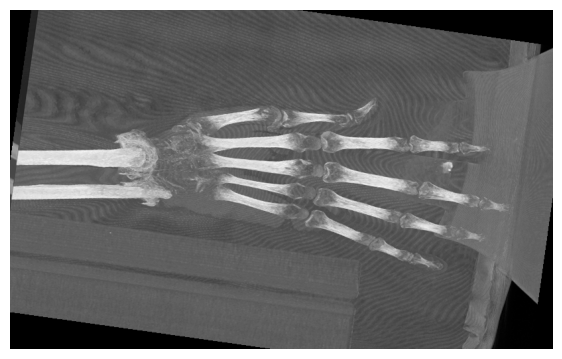

In [110]:
gray_image = mpimg.imread('gray_image11_a.png')

# Отображение изображения в оттенках серого
plt.figure(figsize=(7, 7))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

# 8.2 создание и сохранение контрастного изображения

In [111]:
image22 = Image.open('gray_image11_a.png')
                
enhancer = ImageEnhance.Contrast(image22) # Создание объекта для улучшения контрастности
enhanced_image = enhancer.enhance(2.0) # Увеличение контрастности в 2 раза
enhanced_image.save('image11_contrast_a.png')

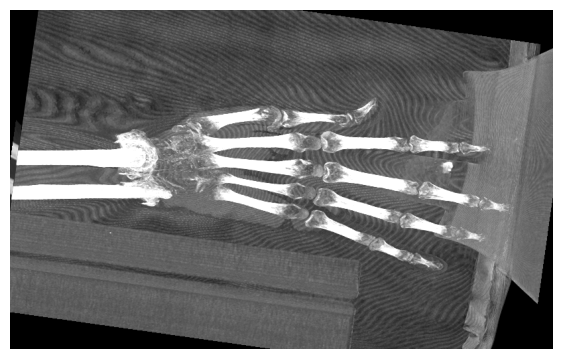

In [112]:
plt.figure(figsize=(7, 7))
image71 = mpimg.imread('image11_contrast_a.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71, cmap='gray') # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

# 9. Определения угла сустава в ГРАДУСАХ и перепада костей в ПИКСЕЛЯХ

#### 9.1 Поворот на 90 градусов

In [113]:
input_path = 'image11_contrast_a.png'
# Путь для сохранения преобразованного изображения
output_path = 'image11_contrast_rotated_a.png'

# Загрузка изображения
image = Image.open(input_path)

# Поворот изображения на 90 градусов против часовой стрелки
rotated_image = image.rotate(90, expand=True)

# Сохранение преобразованного изображения
rotated_image.save(output_path)

print(f"Image saved to {output_path}")

Image saved to image11_contrast_rotated_a.png


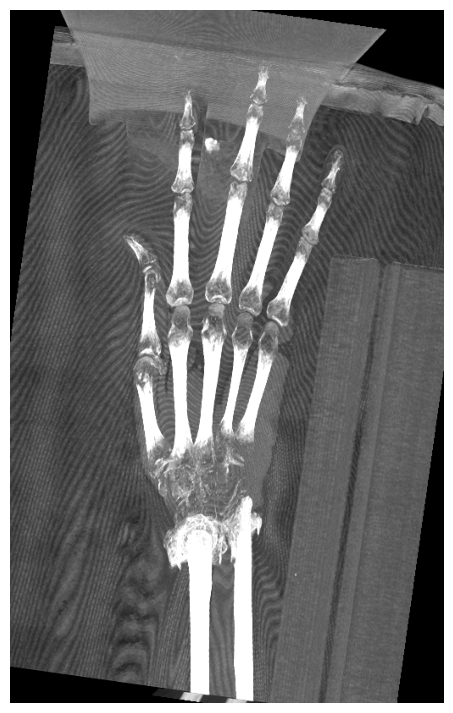

In [114]:
plt.figure(figsize=(9, 9))
image717 = mpimg.imread('image11_contrast_rotated_a.png') # ОТКРЫТИЕ массива
plt.imshow(image717, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image717, cmap='gray') # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

#### 9.2 определение угла сустава В ГРАДУСАХ

In [115]:
import cv2
import numpy as np

# Чтение изображения
image = cv2.imread('image11_contrast_rotated_a.png')
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: image1_contrast.png')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []
drawing = False

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, drawing, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append((x, y))

        if len(clicks) == 2:
            # Построить прямую линию №1, проходящую через ВСЁ изображение
            p1, p2 = clicks
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
            intercept = p1[1] - slope * p1[0]

            x_coords = np.array([0, image.shape[1]])
            y_coords = slope * x_coords + intercept
            cv2.line(overlay, (x_coords[0], int(y_coords[0])), (x_coords[1], int(y_coords[1])), (255, 0, 0), 2)
            
            drawing = True

            # Вычисление угла между линией №1 и горизонтом
            angle = np.degrees(np.arctan2(slope, 1))
            angle = abs(angle)

            print(f'Угол между линией №1 и горизонтом: {angle:.1f} градусов')

            # Вывод угла на изображение
            cv2.putText(overlay, f'{angle:.1f} градусов', (10, image.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        elif len(clicks) == 3:
            # Построить горизонтальную линию через третий клик
            p3 = clicks[2]
            cv2.line(overlay, (0, p3[1]), (image.shape[1], p3[1]), (0, 255, 0), 2)
            print(f'Горизонтальная линия нарисована через точку: {p3}')

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Сохранение измененного изображения
cv2.imwrite('image11_contrast_edited_ang.png', overlay)

cv2.destroyAllWindows()

Угол между линией №1 и горизонтом: 36.5 градусов
Горизонтальная линия нарисована через точку: (497, 414)


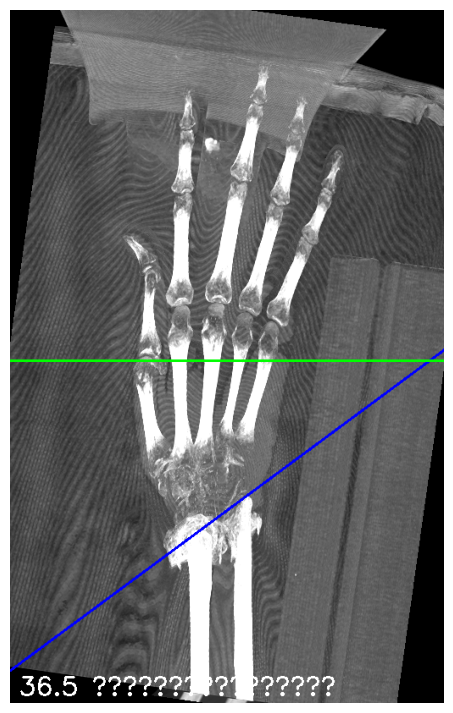

In [116]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('image11_contrast_edited_ang.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()

#### 9.3 Определение перепада высот костей в суставе В ПИКСЕЛЯХ

In [117]:
image_path = 'image11_contrast_rotated_a.png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f'Не удалось загрузить изображение по пути: {image_path}')

# Создание холста для отрисовки линий
overlay = image.copy()

# Список для хранения координат кликов
clicks = []

# Обработчик событий мыши
def mouse_callback(event, x, y, flags, param):
    global clicks, overlay
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicks.append(y)  # Сохраняем только координату y для горизонтальных линий

        if len(clicks) == 1:
            cv2.line(overlay, (0, y), (image.shape[1], y), (255, 0, 0), 2)
        elif len(clicks) == 2:
            cv2.line(overlay, (0, y), (image.shape[1], y), (0, 255, 0), 2)

            # Расчет расстояния между линиями по вертикали
            a = abs(clicks[1] - clicks[0])
            print(f'Расстояние между линиями: {a} пикселей')

            # Вывод расстояния на изображение внизу
            text_position = (10, image.shape[0] - 10)
            cv2.putText(overlay, f'{a} пикселей', text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Показать обновленное изображение
            cv2.imshow('Изображение', overlay)

            # Сохранение измененного изображения
            cv2.imwrite('image11_contrast_edited_a_h.png', overlay)

# Привязка обработчика событий к окну изображения
cv2.namedWindow('Изображение')
cv2.setMouseCallback('Изображение', mouse_callback)

# Отображение изображения с наложенными линиями
while True:
    cv2.imshow('Изображение', overlay)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

Расстояние между линиями: 40 пикселей


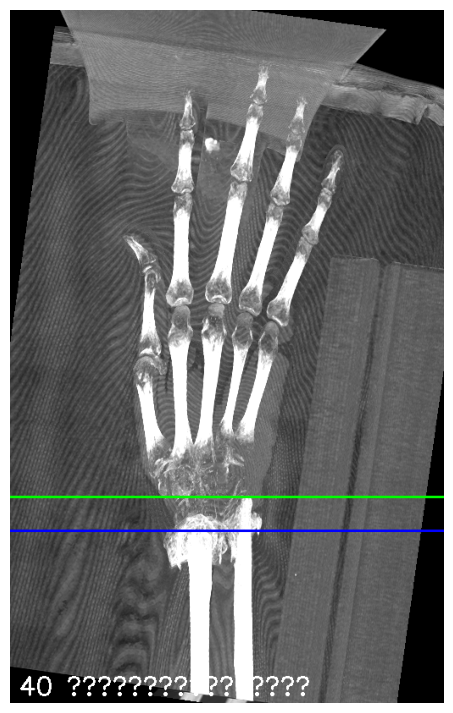

In [118]:
plt.figure(figsize=(9, 9))
image71 = mpimg.imread('image11_contrast_edited_a_h.png') # ОТКРЫТИЕ массива
plt.imshow(image71, aspect='auto') # УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ
plt.imshow(image71) # ПОКАЗАТЬ что там
plt.axis('off')  # Выключить оси графика + УБРАТЬ ДОПОЛНИТЕЛЬНУЮ РАМКУ = РАБОТАЮТ ПАРОЙ
plt.show()